# Data Prep and Exploratory Analysis
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./docker-custom-image/requirements.txt

## This notebook will help you to do:
* Import raw data from Amazon Athena
* Feature Engineering
* Univariate Analysis
* Bivariate Analysis
* Save final dataset with the selected features to CSV to train the model

# 1. Parameters

In [1]:
#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

In [2]:
# !pip -q install -r requirements.txt

In [3]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')
except:
    pass

In [4]:
import json
import pandas as pd
import numpy as np
import sweetviz as sv
from io import StringIO
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Import raw data from CSV

## Para mais detalhes sobre a base do Titanic, consulte seu [link](https://www.kaggle.com/competitions/titanic/data) no Kaggle

In [5]:
dataprep_df_full = pd.read_csv('./titanic/train.csv')
dataprep_df_full

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
#Na base do Titanic não tem a variável de Data de Referencia, mas vamos criar essa variável apenas para mostrar como o código funciona com uma base que tem Safra 
random.seed(1)
for i in range(len(dataprep_df_full)):
    dataprep_df_full.loc[i, (VarDate)] = random.choice(['1912-04','1912-05','1912-06', '1912-07'])

In [7]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)

## 2.1 Analyse the target variable

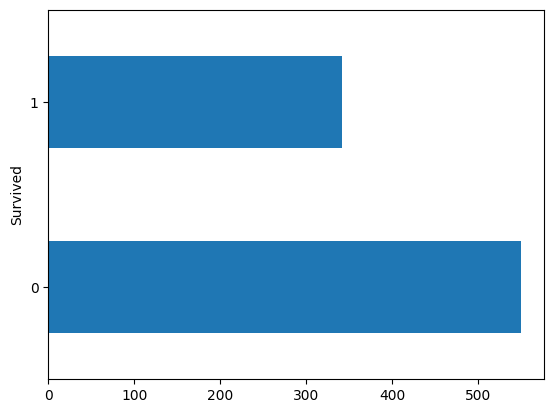

In [8]:
dataprep_df.groupby([VarTarget])[VarId].count().plot(kind='barh')

## 2.2 Define the data time period for used to traing de model

In [9]:
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget]].groupby(VarDate).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]

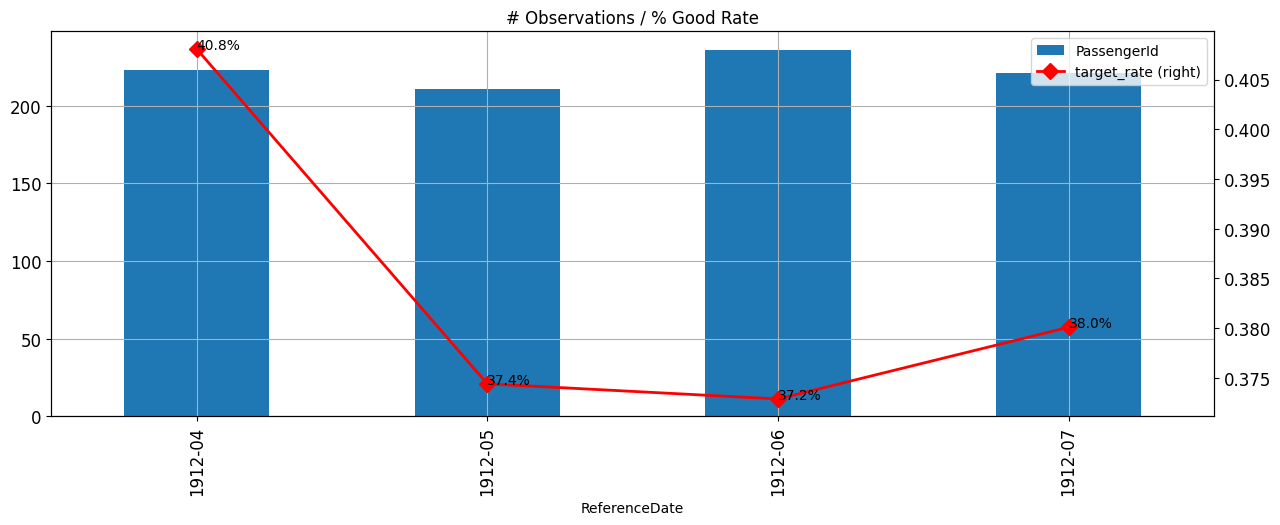

In [10]:
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,3]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,3]*1))        

## 2.3 Separate the dataset into Traning and Test, ensuring the test dataset is an out of time sample

In [11]:
##Defined out of time validation (1912-07)
dataprep_df['dataset'] = ['train' if x <= '1912-06' else 'test' for x in dataprep_df[VarDate]]

In [12]:
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


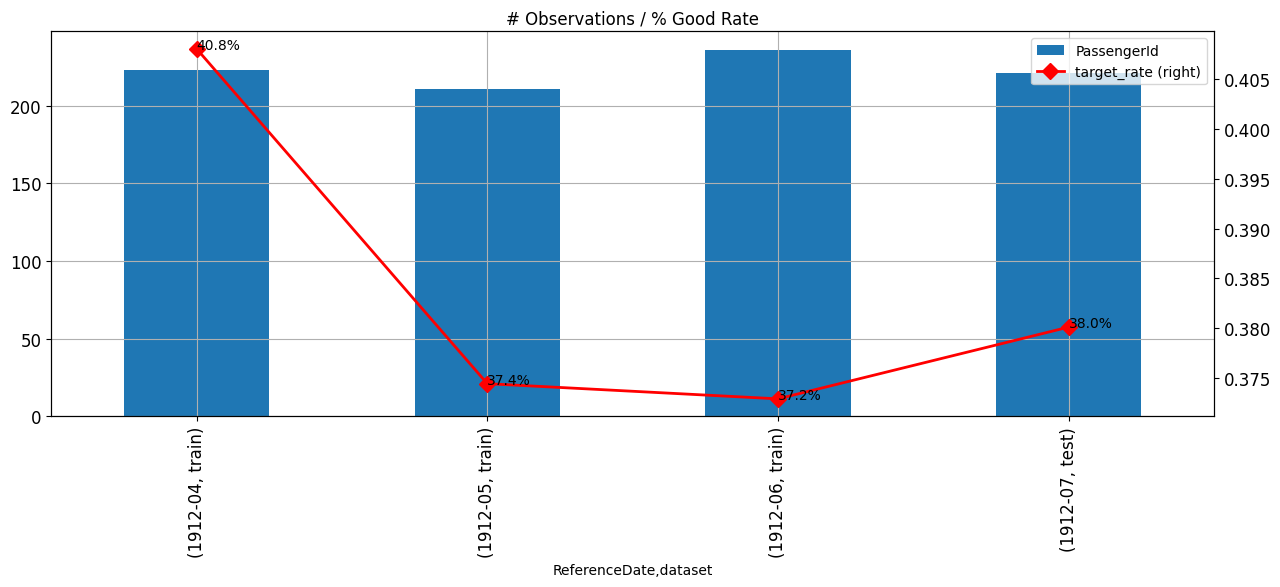

In [13]:
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

# 3. Feature Engineering

In [14]:
#criar o prefix para a variavel cabine (A, B, C, D, ou E)
dataprep_df['cabine_prefix'] = dataprep_df['Cabin'].str[0:1]
dataprep_df = dataprep_df.fillna(value={'cabine_prefix': 'missing'})

In [15]:
#Tiket
import re
for i in range(len(dataprep_df)):
    t=dataprep_df.loc[i:i,'Ticket'].values
    t2=re.sub("[^0-9]", "", str(t))
    t3=re.sub('[^A-Za-z]+', '', str(t))
    if t2 != "":
        dataprep_df.loc[i:i,'Ticket_int']=int(t2)
    if t3 != "":
        if t3 == 'SC':
            t3 = 'SCAHBasle'
        if t3 == 'SOP':
            t3 = 'SOPP'
        if t3 == 'C':
            t3 = 'CA'
        if t3 == 'FC':
            t3 = 'FCC'
        if t3 == 'PP':
            t3 = 'PPP'
        if t3 == 'SCOW':
            t3 = 'Fa'
        if t3 in ('AS', 'CASOTON', 'Fa', 'SCA','SOPP','SOTONO','SP'):
            t3='LOW'
    dataprep_df.loc[i:i,'Ticket_str']=str(t3)

dataprep_df['Ticket_int'] = dataprep_df['Ticket_int'].fillna(0)
dataprep_df = dataprep_df.fillna(value={'Ticket_str': 'missing'})

In [16]:
#Name: Criar uma categoria com o titulo do nome
for i in range(len(dataprep_df)):
    t1 = str(dataprep_df.loc[i:i,'Name'].values)
    t2 = t1[0:t1.find('.')].split()[-1]
    if t2 in ('Rev', 'Capt', 'Don', 'Jonkheer'):
        t2='LOW'
    if t2 in ('Lady', 'Mme'):
        t2='Miss'
    dataprep_df.loc[i:i,'NameTitle']=str(t2)

## 3.1 Treatment of Numeric Missing Data

In [17]:
#Create the "Missing" category for missing values in string vaviables
dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [18]:
#Tratamento da idade
dataprep_df['Age_Mean'] = dataprep_df['Age'].fillna(dataprep_df['Age'].mean())

# 4. Univariate Analysis

## 4.1 EDA with Sweetviz

##### For more details on the pandas profiling library see [here](https://github.com/fbdesignpro/sweetviz)


                                             |          | [  0%]   00:00 -> (? left)


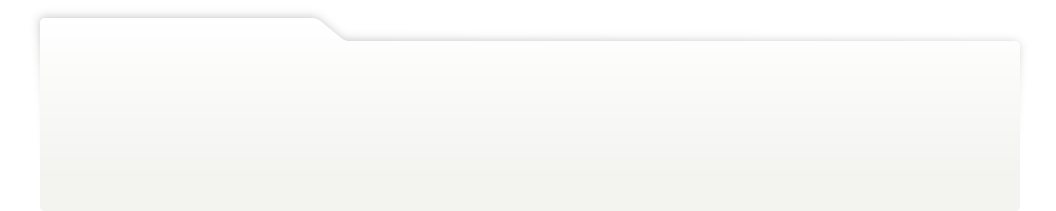
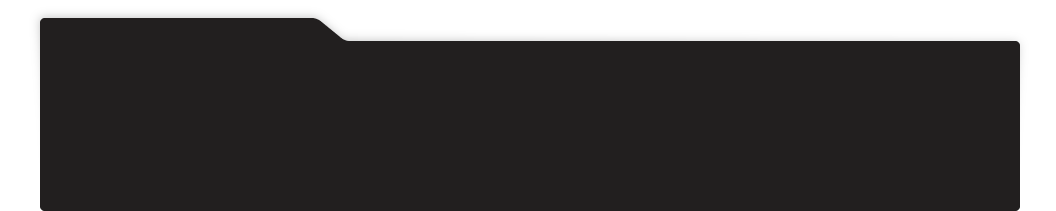
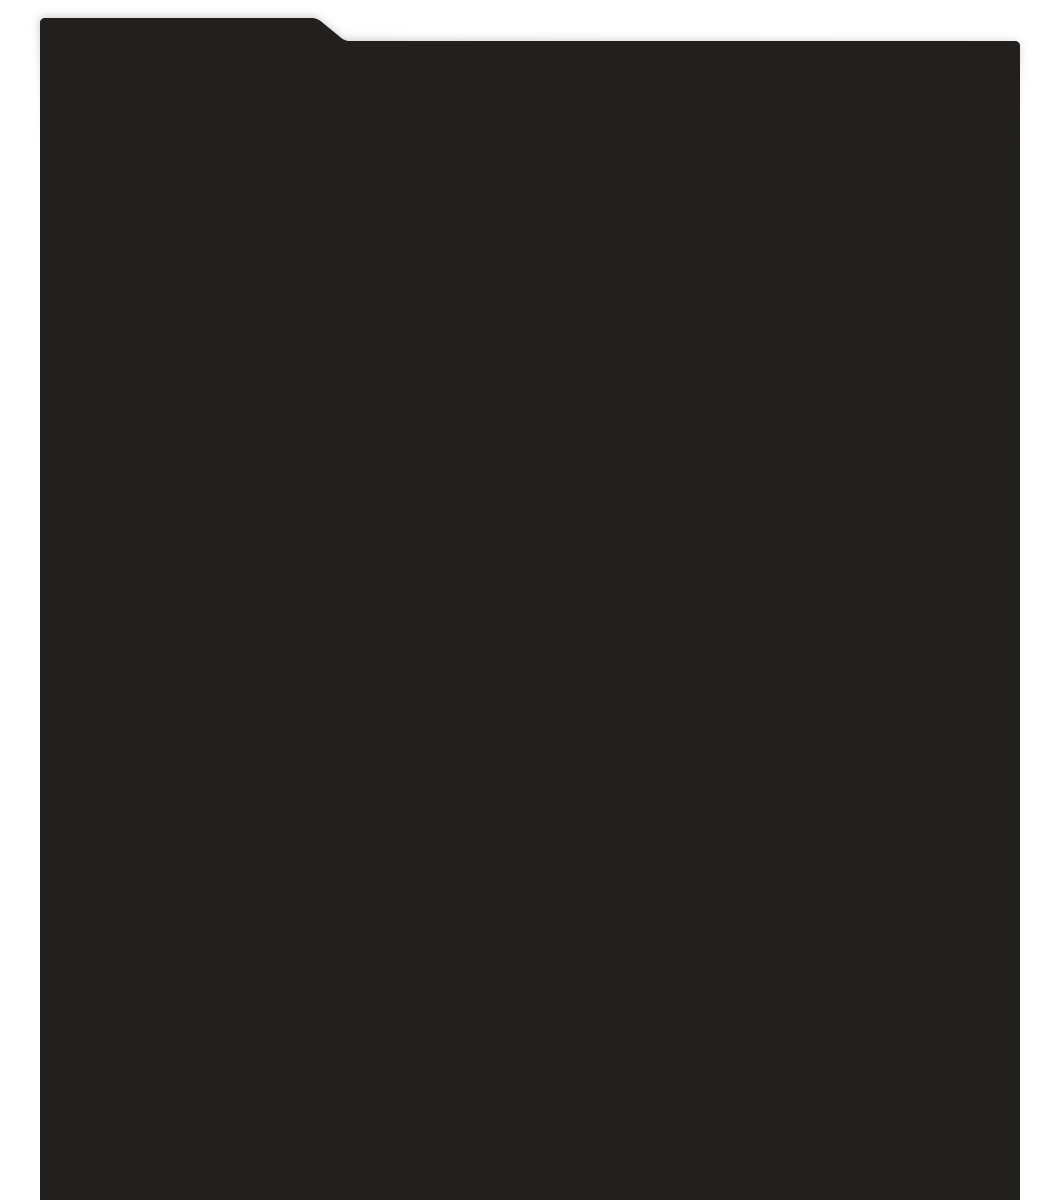
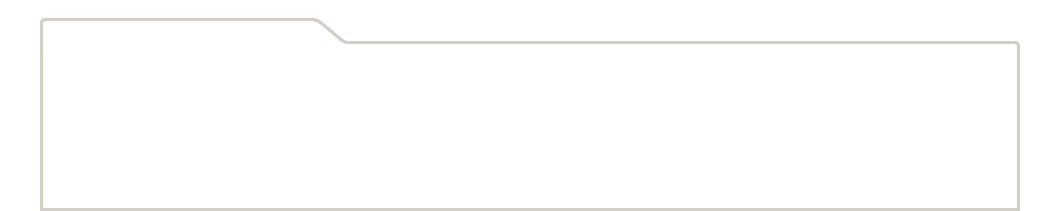
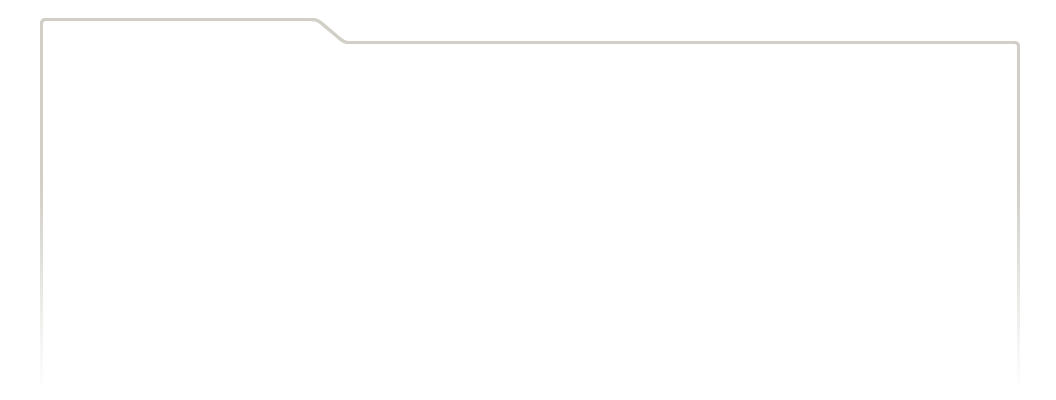
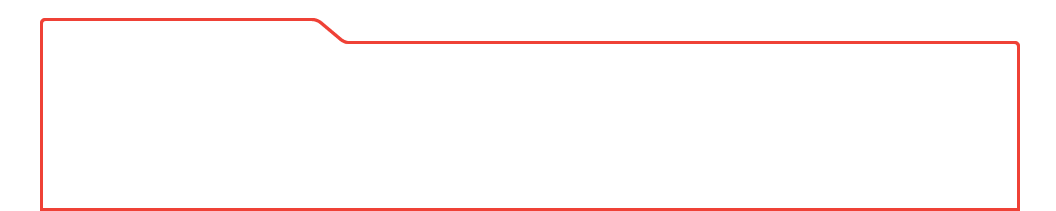
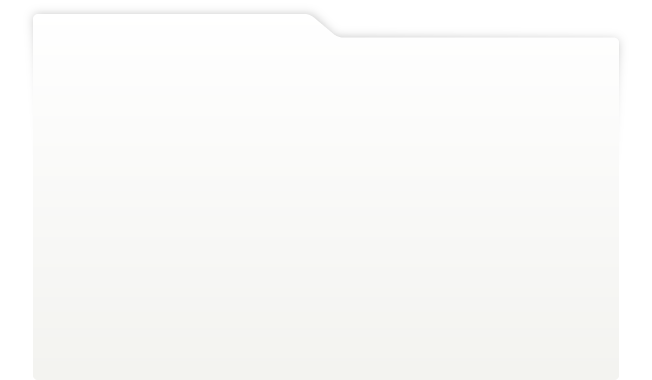
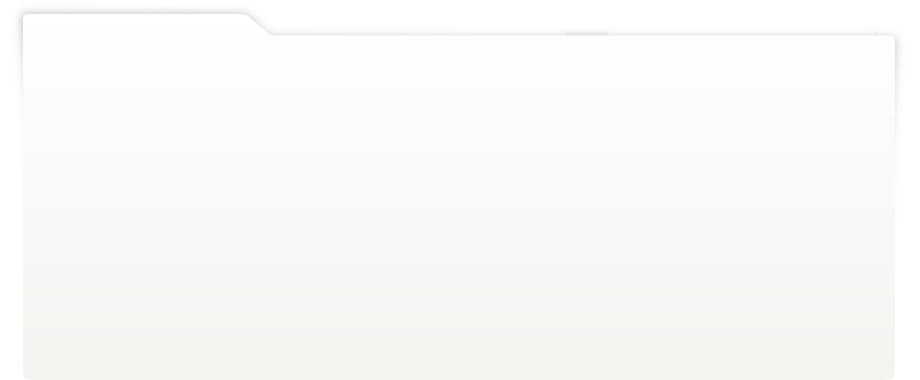
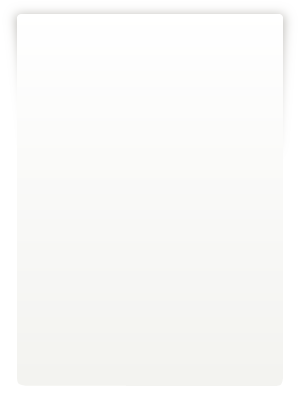
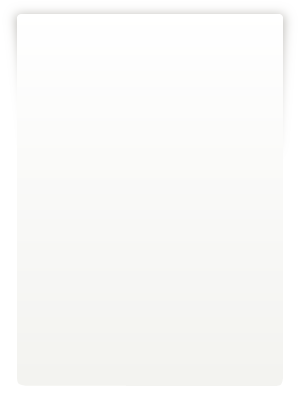
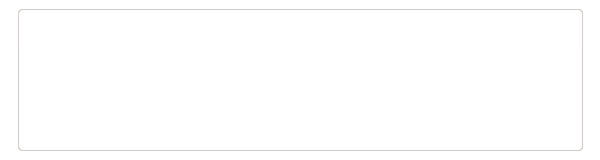
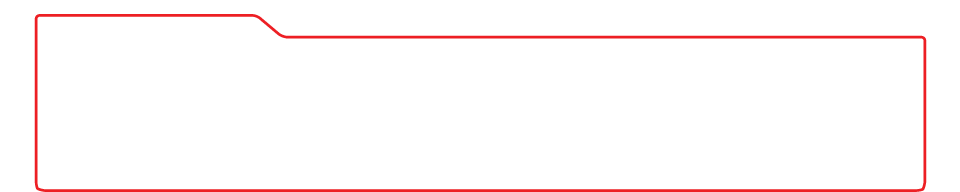
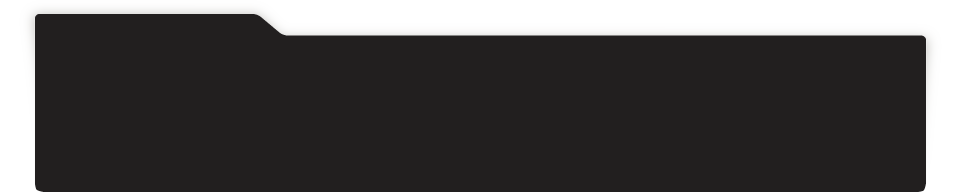
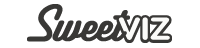
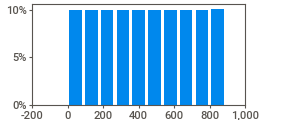
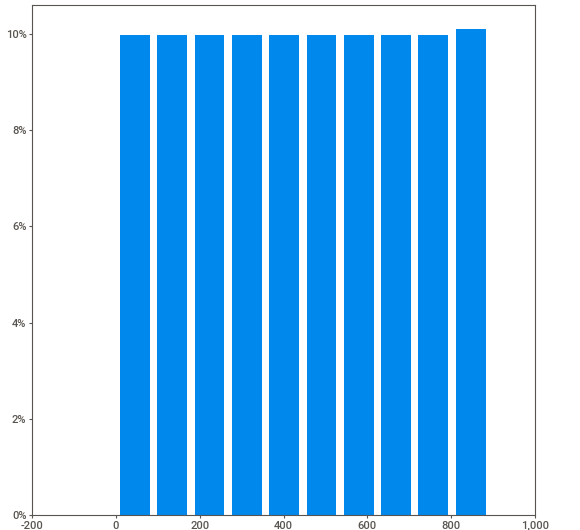
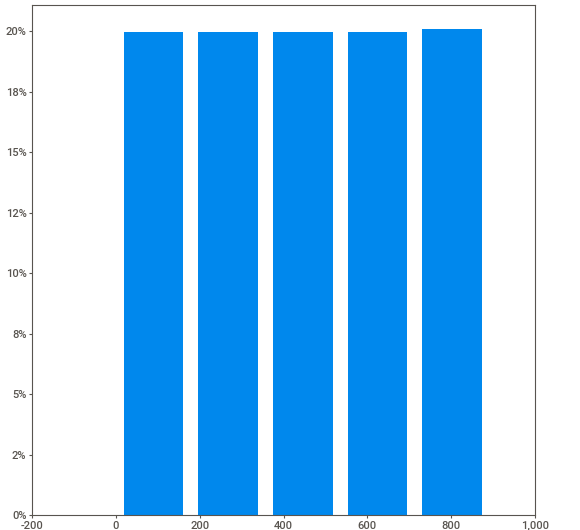
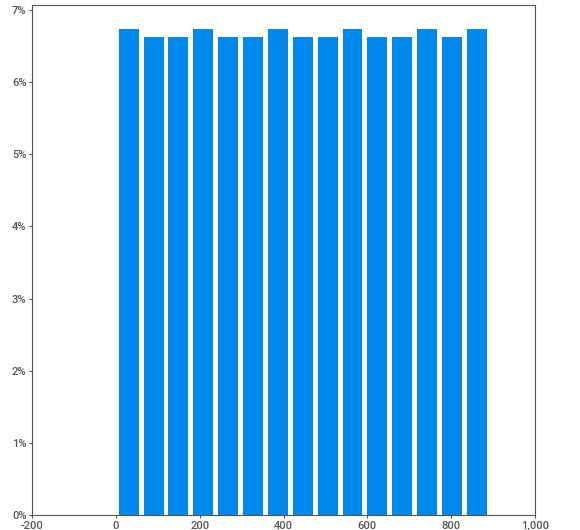
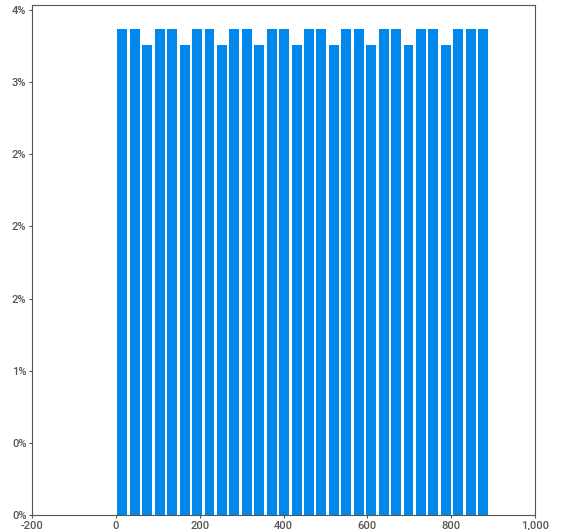
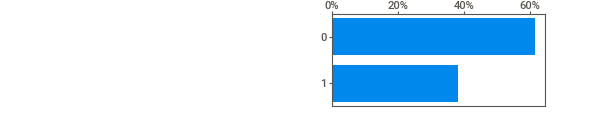
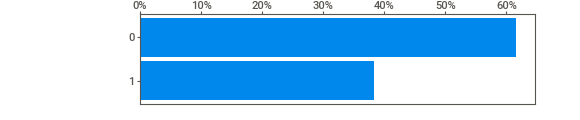
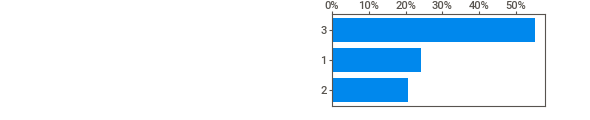
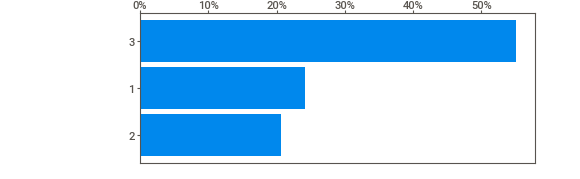
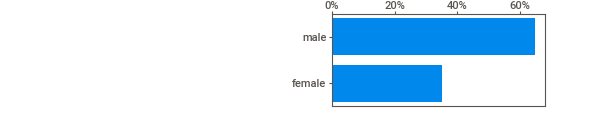
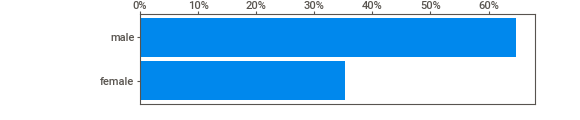
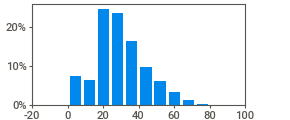
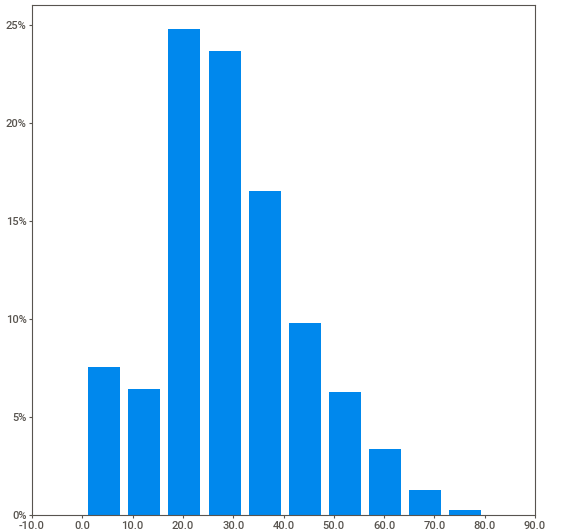
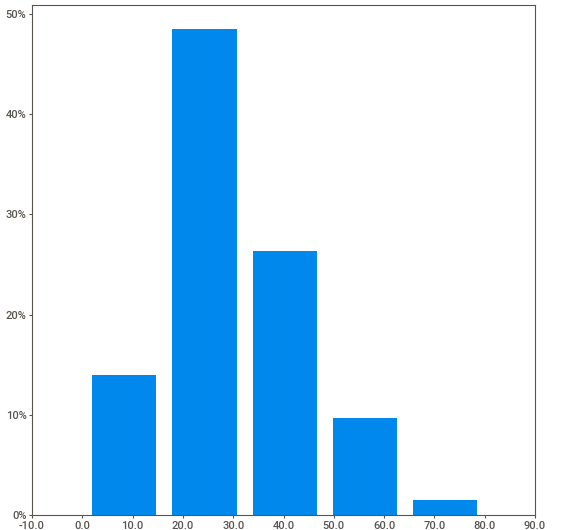
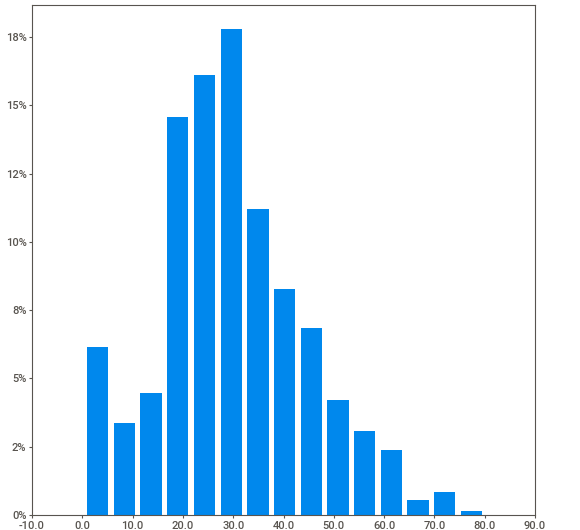
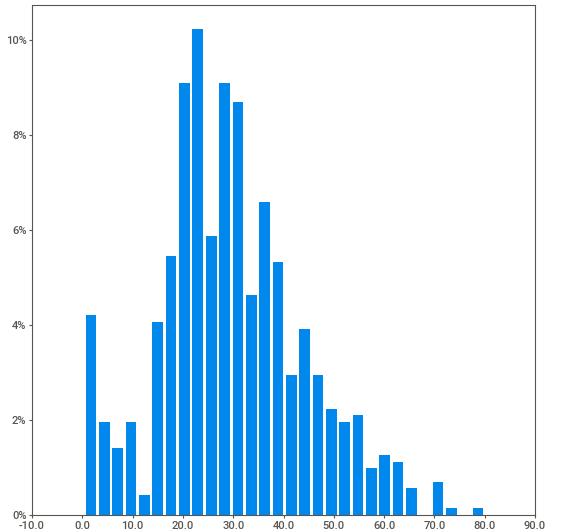
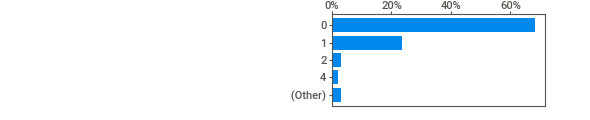
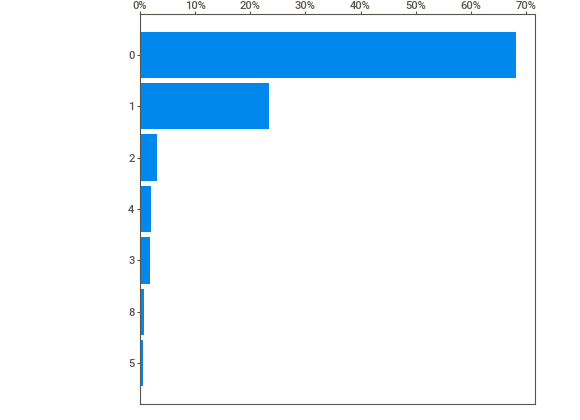
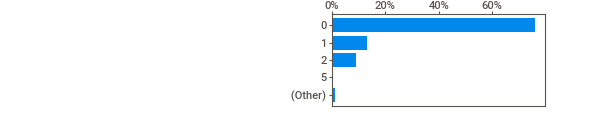
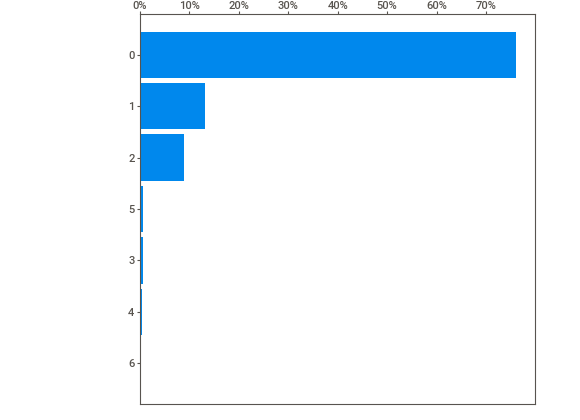
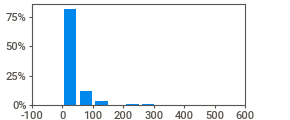
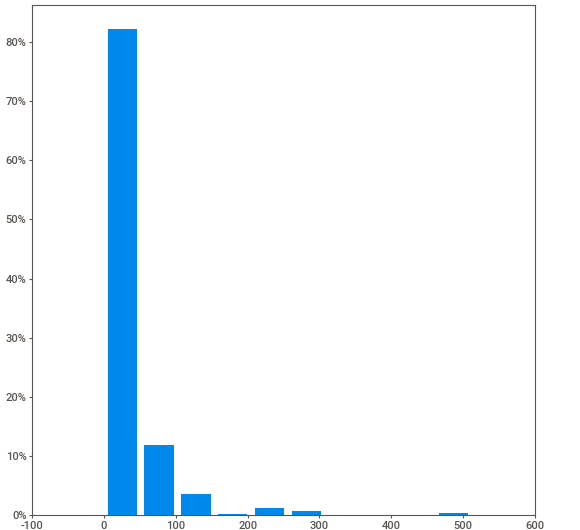
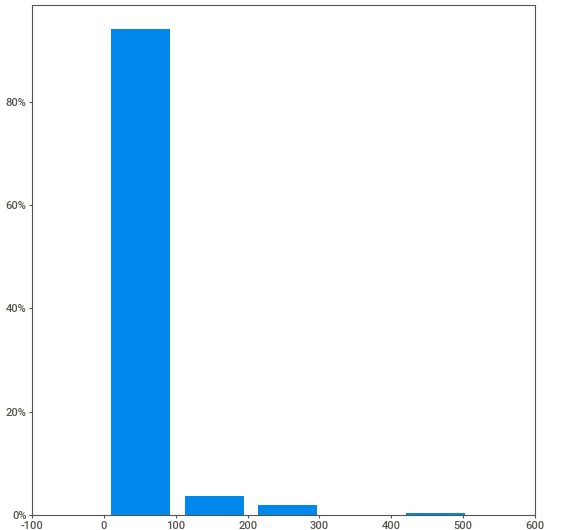
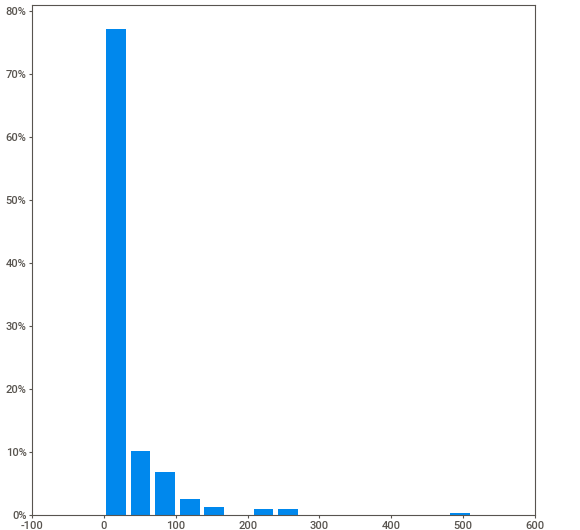
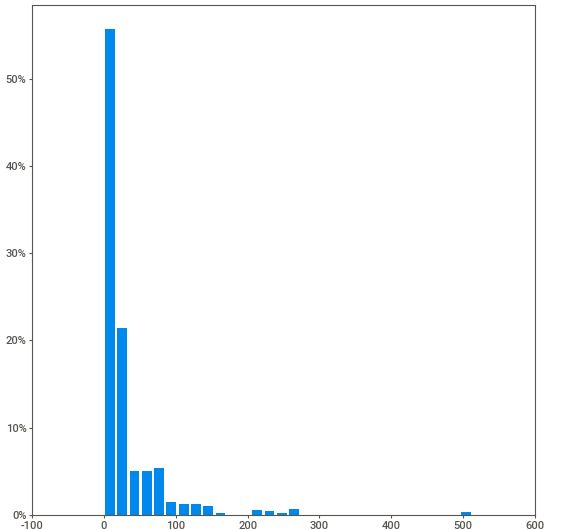
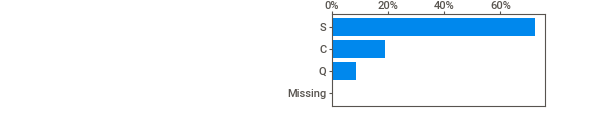
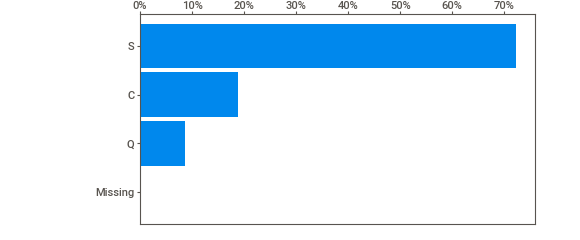
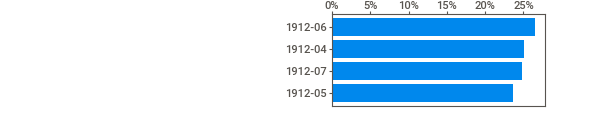
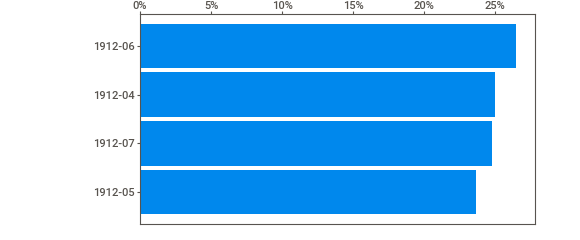
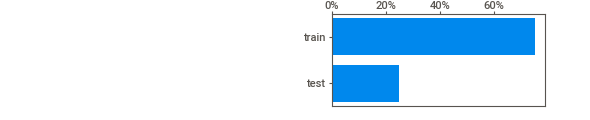
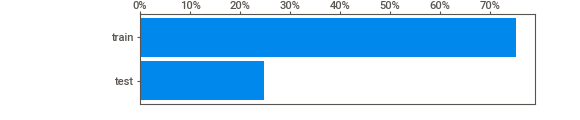
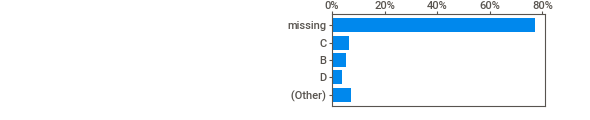
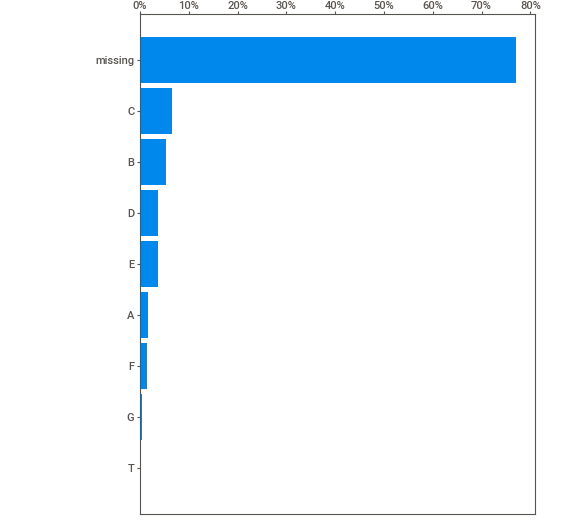
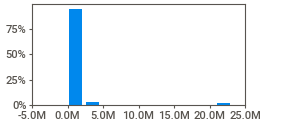
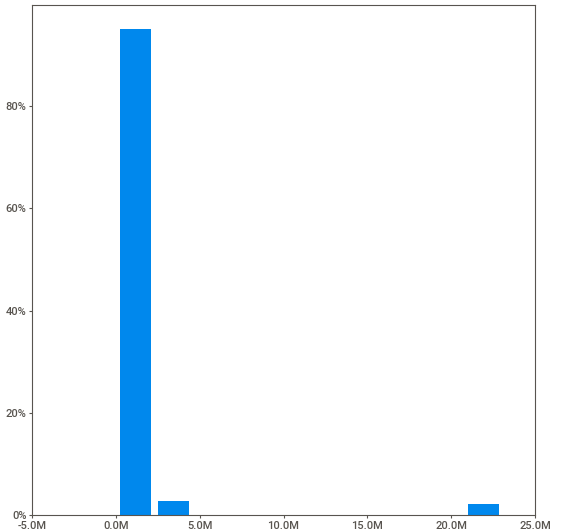
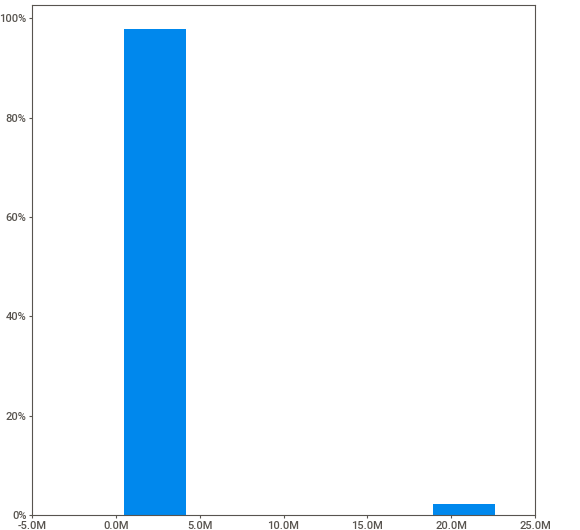
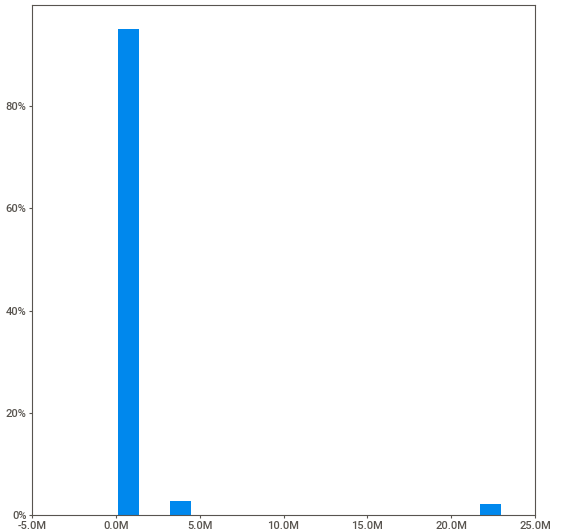
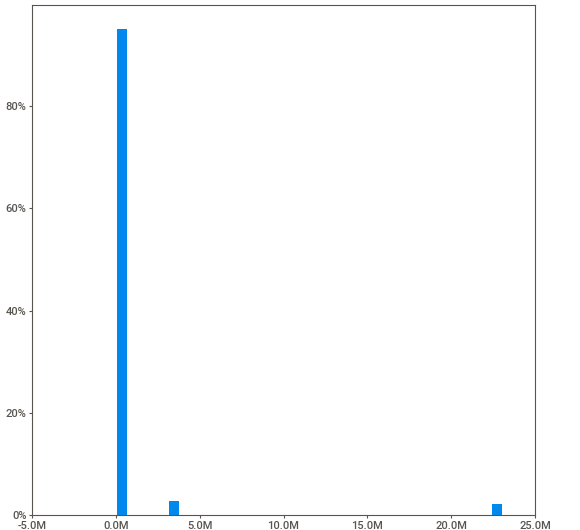
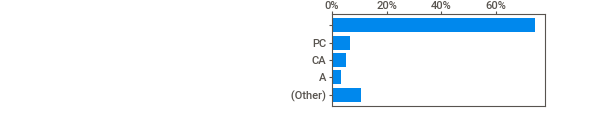
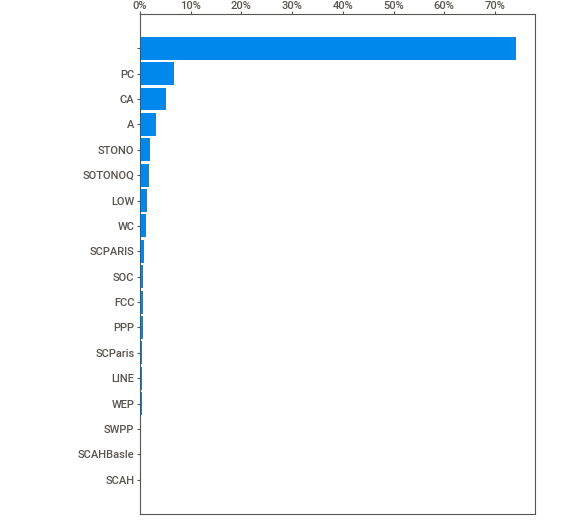
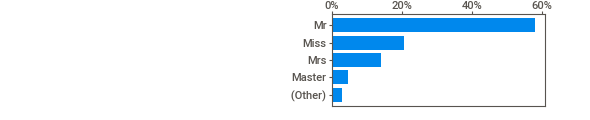
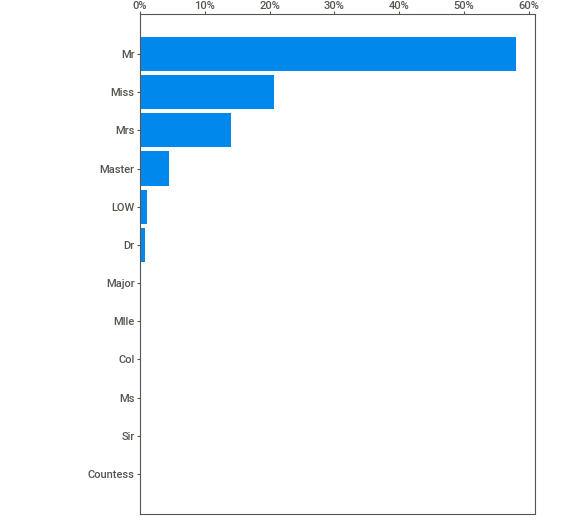
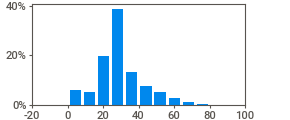
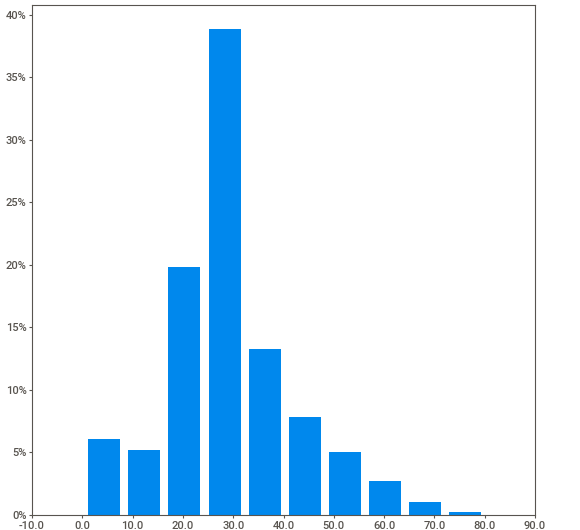
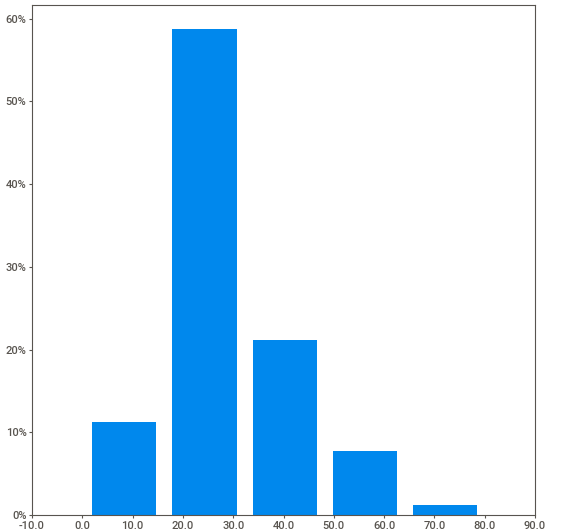
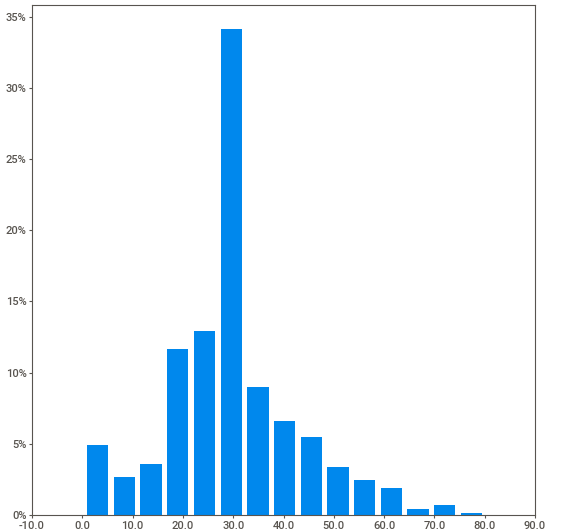
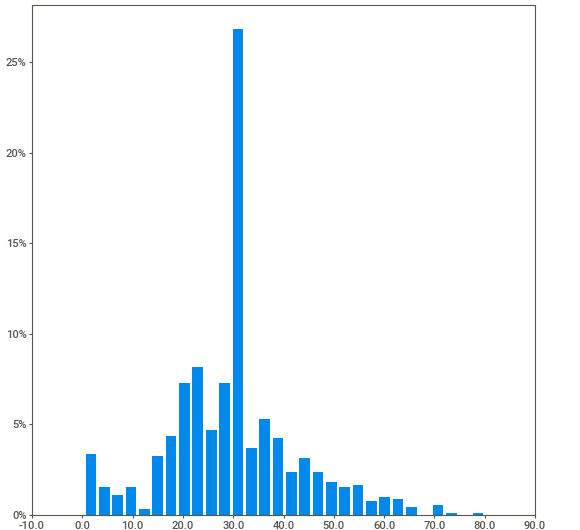
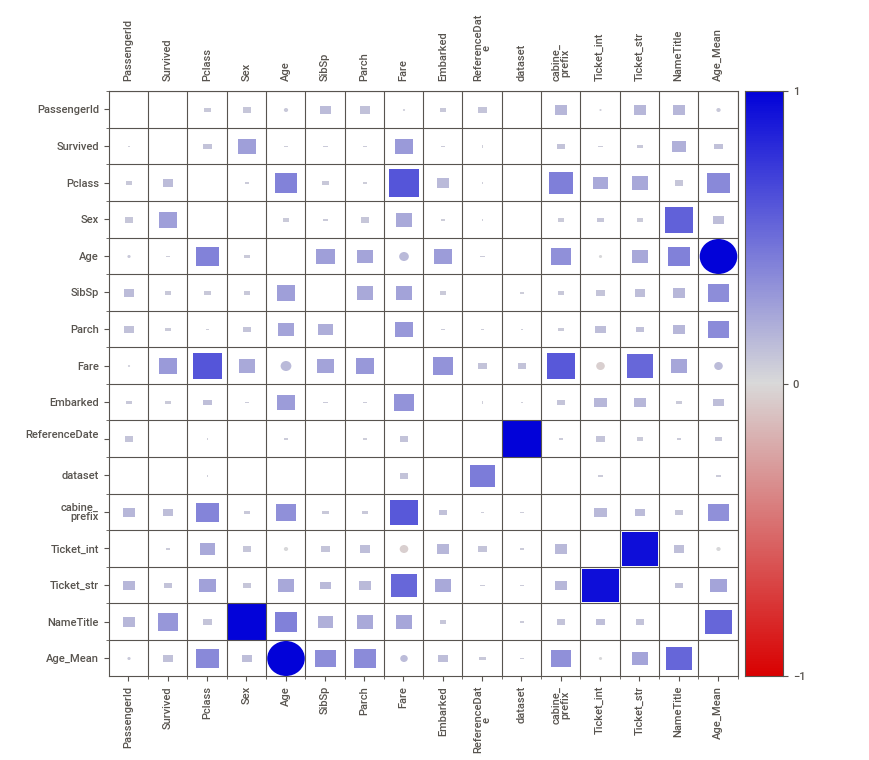
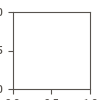

In [19]:
analysis = sv.analyze(dataprep_df)
analysis.show_notebook()

## 4.2 Classify the types of variables
#### list all columns to select the ones to be used

In [20]:
for i in dataprep_df.columns:
    print(i + ": " + analysis.get_type(i).name)

PassengerId: TYPE_NUM
Survived: TYPE_BOOL
Pclass: TYPE_CAT
Name: TYPE_TEXT
Sex: TYPE_CAT
Age: TYPE_NUM
SibSp: TYPE_CAT
Parch: TYPE_CAT
Ticket: TYPE_TEXT
Fare: TYPE_NUM
Cabin: TYPE_TEXT
Embarked: TYPE_CAT
ReferenceDate: TYPE_CAT
dataset: TYPE_CAT
cabine_prefix: TYPE_CAT
Ticket_int: TYPE_NUM
Ticket_str: TYPE_CAT
NameTitle: TYPE_CAT
Age_Mean: TYPE_NUM


### From the variables listed above you can select which  one will be tested in the model and confirm if the correct type is numeric(NUM) or categorical (CAT). Paste the correct information below:

In [21]:
#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

#float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

In [22]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

## 4.2 Outlier Analysys with Box plot and Violin Plot

In [23]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    plt.show()

Fare


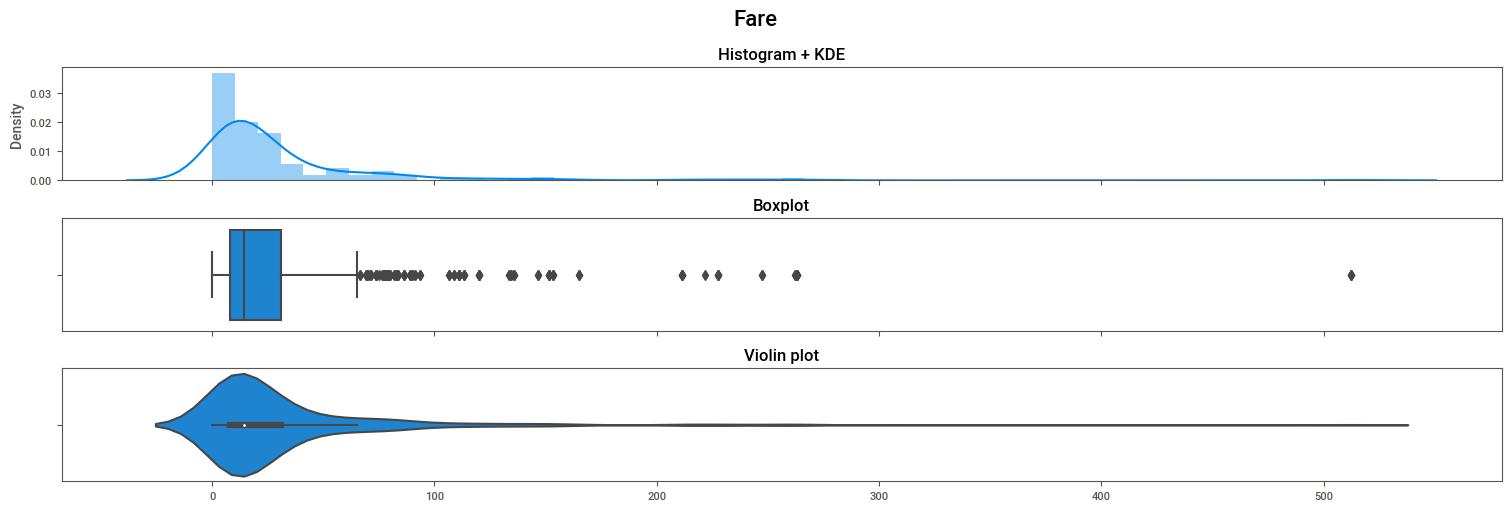

SibSp


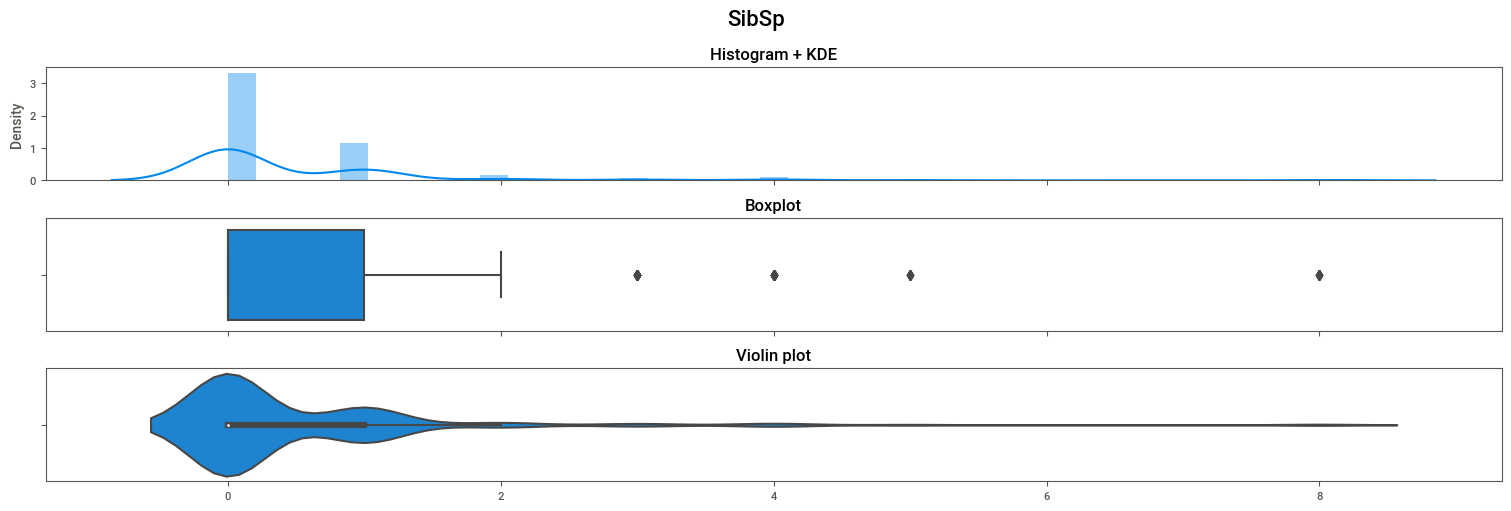

Parch


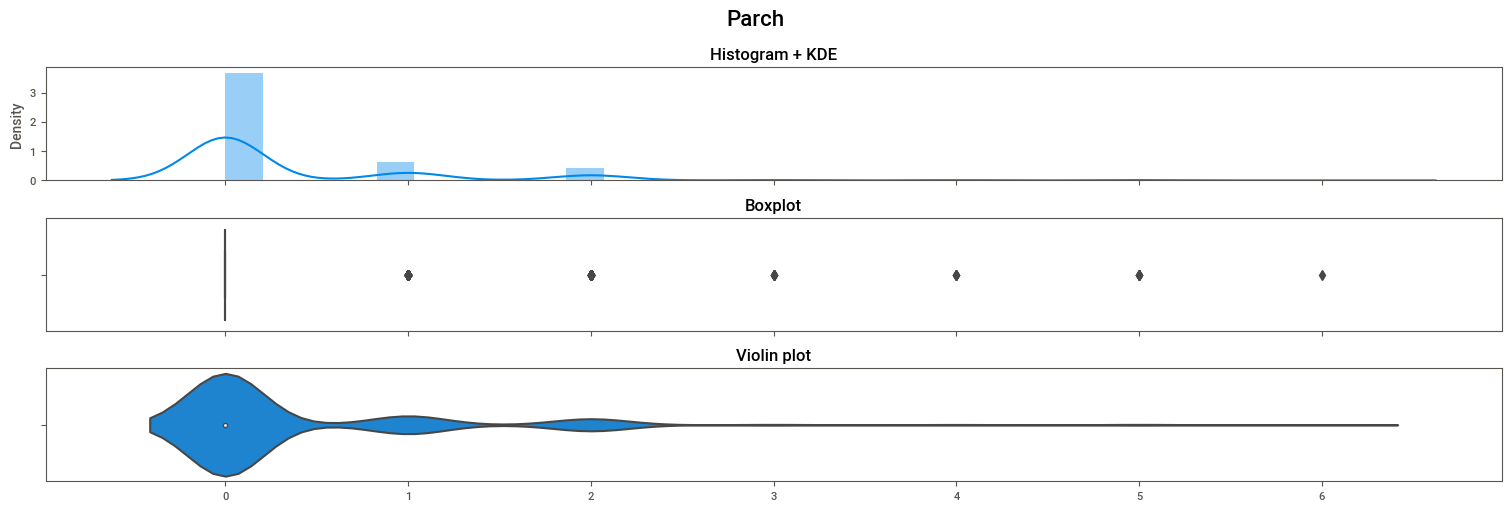

Age_Mean


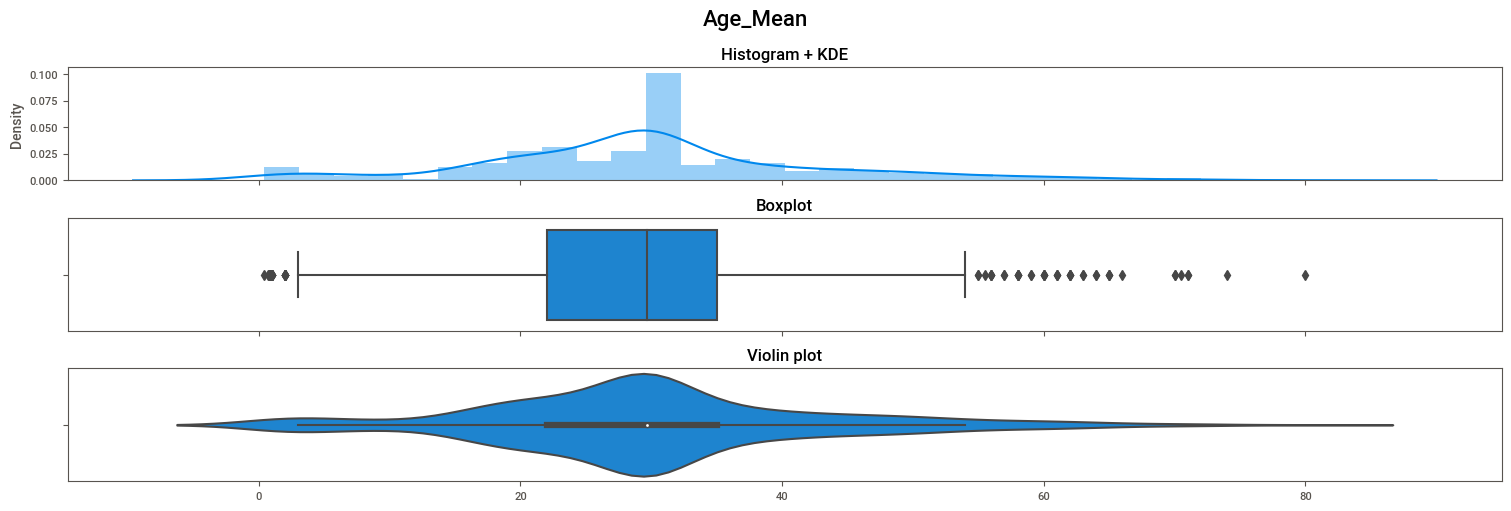

Ticket_int


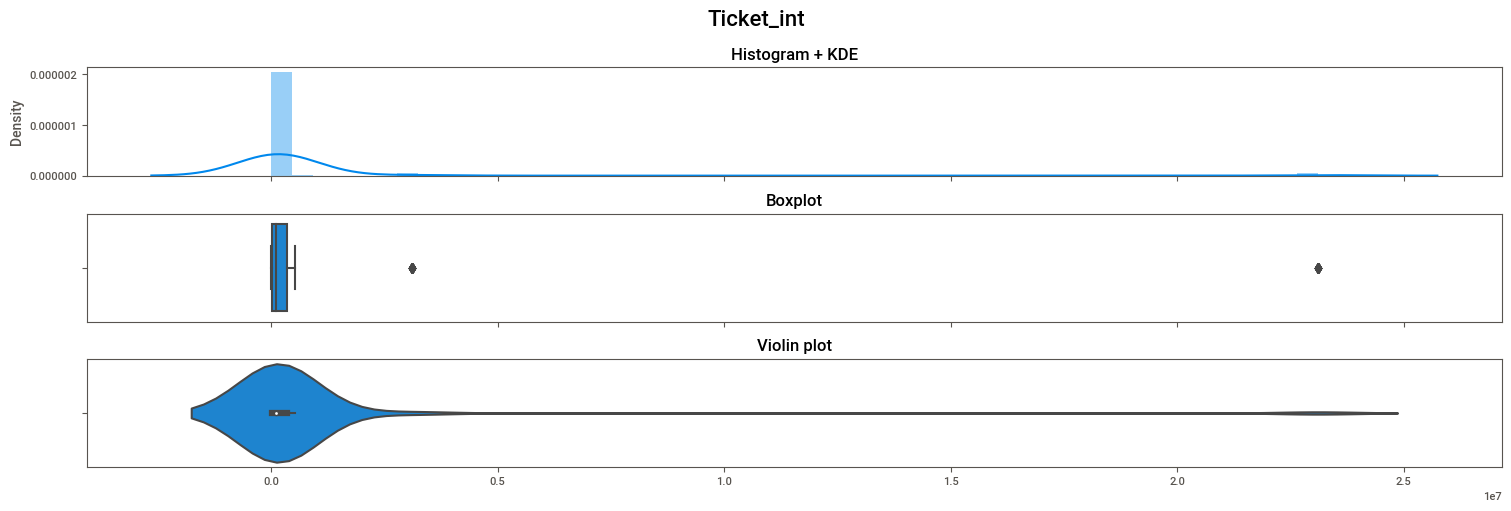

In [24]:
## Distribution analysis of numerical variables
for i in NUM:
    print(i)
    plot_comparison(dataprep_df[i], i)

## 4.3 Outliers Removing

Low: 0.0
High: 345.27863600001024
Reduction: -0.34% | 3


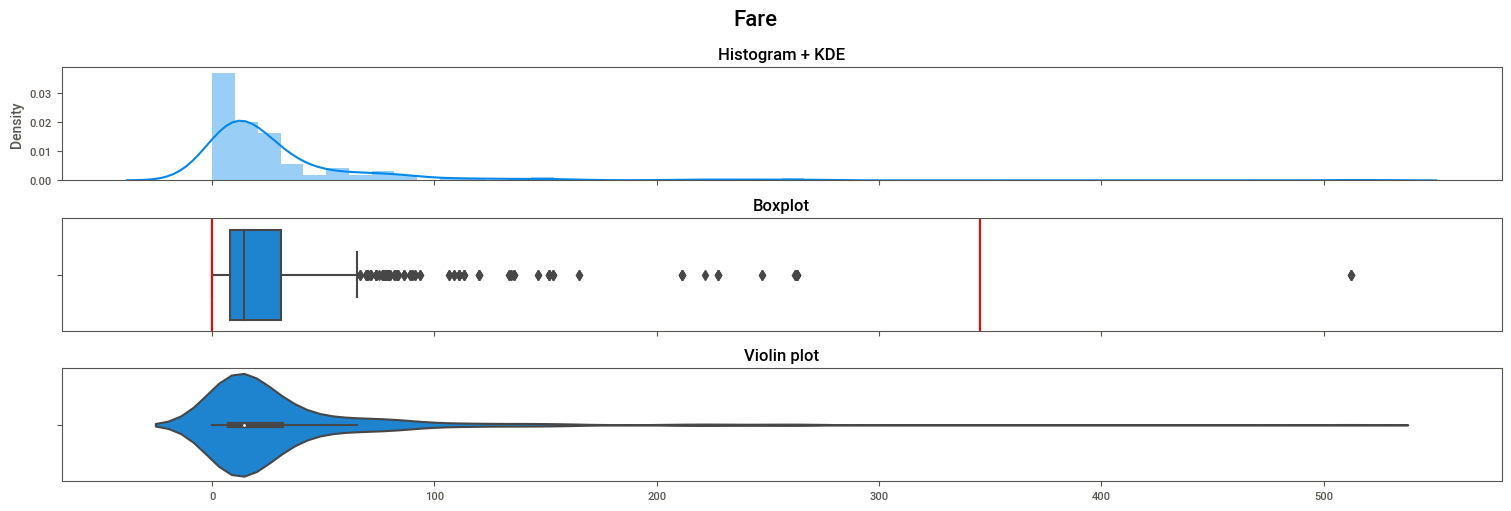

In [25]:
var = 'Fare'

q_low = dataprep_df[var].quantile(0)
q_hi  = dataprep_df[var].quantile(0.997)
print('Low: ' + str(q_low))
print('High: ' + str(q_hi))
print('Reduction: ' 
      + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
      + " | " 
      + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

def plot_comparison(x, title, low, high):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    # only one line may be specified; full height
    ax[1].axvline(x = low, color = 'red')
    ax[1].axvline(x = high, color = 'red')
    plt.show()
    
plot_comparison(dataprep_df[var], var, q_low, q_hi)

dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 5. Bivariate Analysis

## 5.1 Calculation of the Information Value for all variables defined as selected features

In [26]:
def calculate_IV(dataframe, coluna_feature, coluna_target, cat_goods = None, buckets=20):
    '''
    Function to calculate the IV.
         Parameters
         dataframe: DataFrame with the input and target variables.
         column_feature (str): Name of the variable that contains the independent variable.
         column_target (str): Name of the variable that contains the dependent variable or target.
         cat_goods (str): Level of the target variable that should be considered "GOOD", if it is categorical.
         buckets (int): Number of partitions to be created in numeric variables.
    
    Returns
    stats (list):
    List with:
        [1] IV
        [0] dataframe pandas with statistics table
    '''
    
    # Initial definitions
    df = dataframe.loc[:,(coluna_feature, coluna_target)]
    tpVar = 'categorical'    
    
    #If the variable is numeric (float or int), it creates a category for discretization
    if df[coluna_feature].dtype=='float64' or df[coluna_feature].dtype=='int64' or df[coluna_feature].dtype=='int32' or df[coluna_feature].dtype=='float32':
        tpVar='numeric'
        coluna_feature_bucket = coluna_feature + "_bucket"
        #create buckets using qcut
        df[coluna_feature_bucket] = pd.qcut(df[coluna_feature], buckets, labels=False, duplicates='drop')
        analyse_df = df.groupby(coluna_feature_bucket, dropna=False).agg({coluna_target: ['count', 'sum'], coluna_feature: ['min', 'max']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #Categorical variables
    if tpVar == 'categorical':
        analyse_df = df.groupby(coluna_feature, dropna=False).agg({coluna_target: ['count', 'sum']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #IV Calculation
    analyse_df.loc[:, 'qty_bads'] = analyse_df.loc[:,'qty'] - analyse_df.loc[:,'qty_goods']
    analyse_df.loc[:, 'tot_goods'] = analyse_df.loc[:,'qty_goods'].sum()
    analyse_df.loc[:, 'tot_bads'] = analyse_df.loc[:,'qty_bads'].sum()
    analyse_df.loc[:, 'perc_goods'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'tot_goods']
    analyse_df.loc[:, 'perc_bads'] = analyse_df.loc[:,'qty_bads'] / analyse_df.loc[:,'tot_bads']
    analyse_df.loc[:, 'good_rate'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'qty']
    analyse_df.loc[:, 'odds'] = analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']
    try:
        analyse_df.loc[:, 'ln_odds'] = np.log2(analyse_df['odds'])
    except:
        analyse_df.loc[:, 'ln_odds'] = 0
    analyse_df.loc[:, 'iv_cat'] = (analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']) * analyse_df.loc[:, 'ln_odds']
    
    if tpVar == 'numeric':
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature_bucket, coluna_feature+"_min", coluna_feature+"_max", 'qty', 'good_rate', 'odds', 'iv_cat')]
    else:
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature, 'qty', 'good_rate', 'odds', 'iv_cat')]
        
    df_iv = tabela_pdf.query('iv_cat != inf')['iv_cat'].sum()
    resultado = [df_iv, tabela_pdf]
    return resultado

def colunas_dataframe(dataframe):
    lista_colunas = []
    lista_colunas = [i for i in dataframe.columns if i in selected_features]
    return lista_colunas

def table_iv(dataframe):
    lista_colunas = colunas_dataframe(dataframe)
    dict_resultados = {}
    for col in lista_colunas:
#         print("{0:.0%}".format((lista_colunas.index(col)+1) / (len(lista_colunas)+1)) + ":" + col)              
        dict_resultados[col] = calculate_IV(dataframe=dataframe, coluna_feature=col, coluna_target=VarTarget, buckets=10)
    return dict_resultados

In [27]:
start = dt.datetime.now()

result_data = table_iv(dataprep_df)
result_formated = pd.DataFrame.from_dict(data=result_data, orient='index').reset_index().rename(columns={'index': 'Variable', 0: 'IV'}).drop(columns=1)
result_formated_graph = result_formated.sort_values(by=['IV'], ascending=False)
                                                                                                                 
#Execution time
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+"Execution time: " + str (execution_time)+"\n")


Execution time: 0:00:00.454557



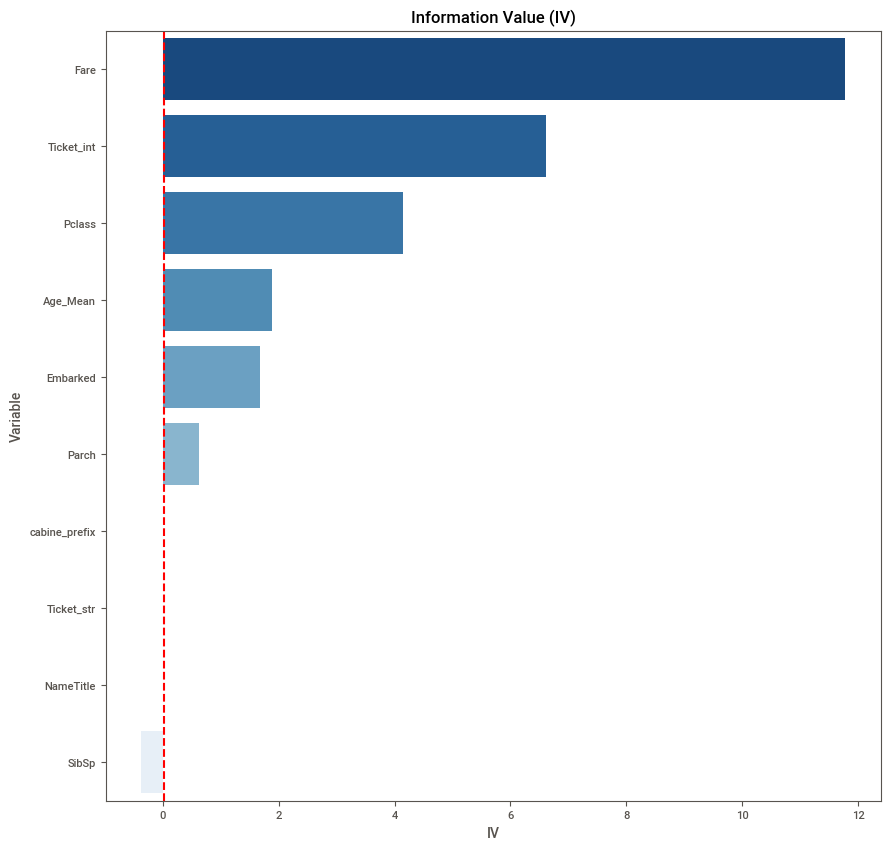

In [28]:
fig = plt.figure(figsize=(10,10))
sns.barplot(y="Variable", x="IV", data=result_formated_graph.head(40), palette="Blues_r").set_title("Information Value (IV)")
plt.axvline (x=0.02, linestyle="--", color='r')

## 5.2 Charts with the good rate (% of target = 1) by categories or by value range for numeric variables (ranges created by decile)

--------------------------------------- Pclass


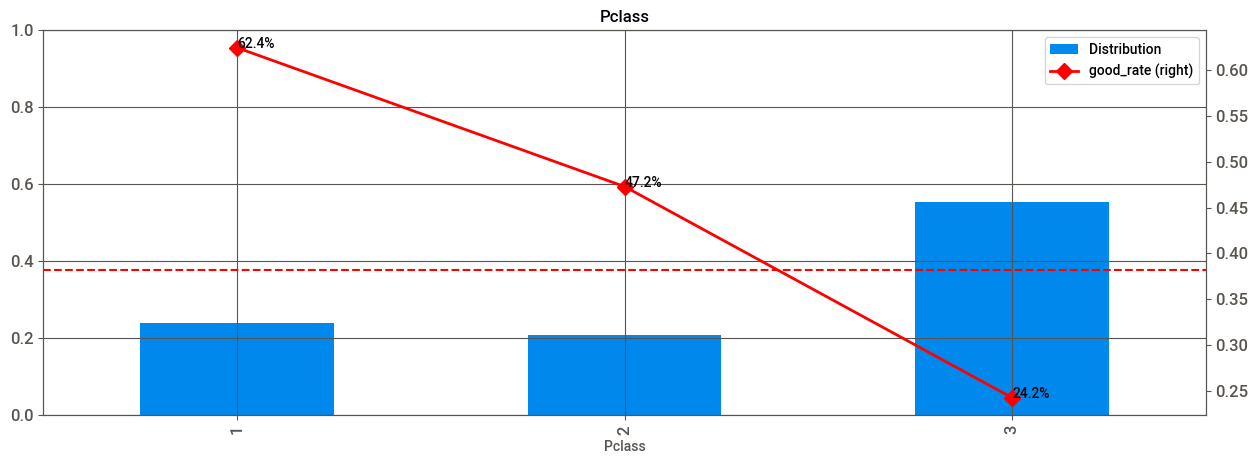

--------------------------------------- Embarked


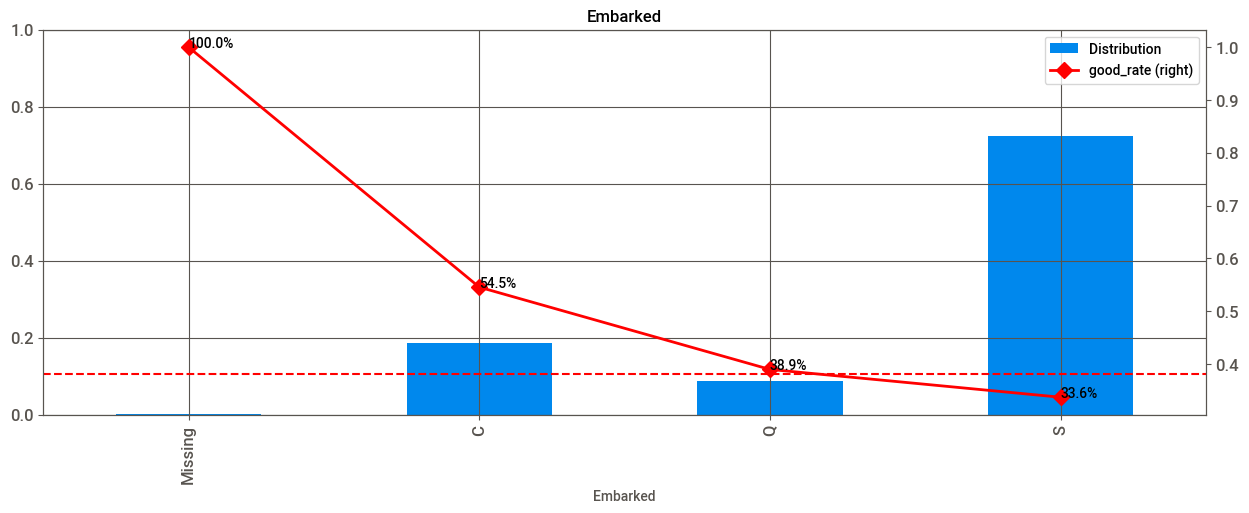

--------------------------------------- cabine_prefix


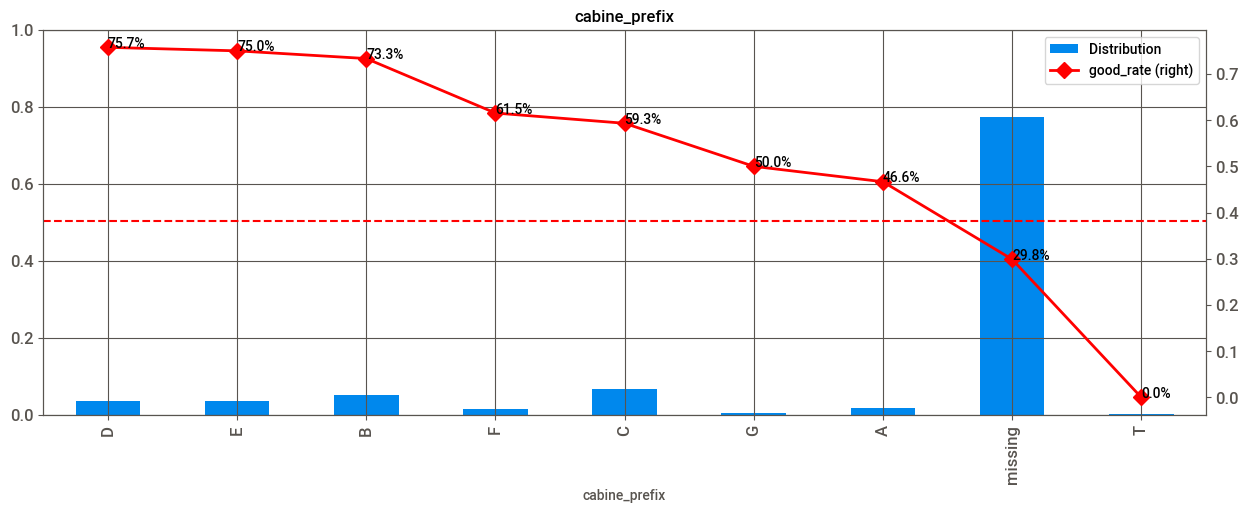

--------------------------------------- Ticket_str


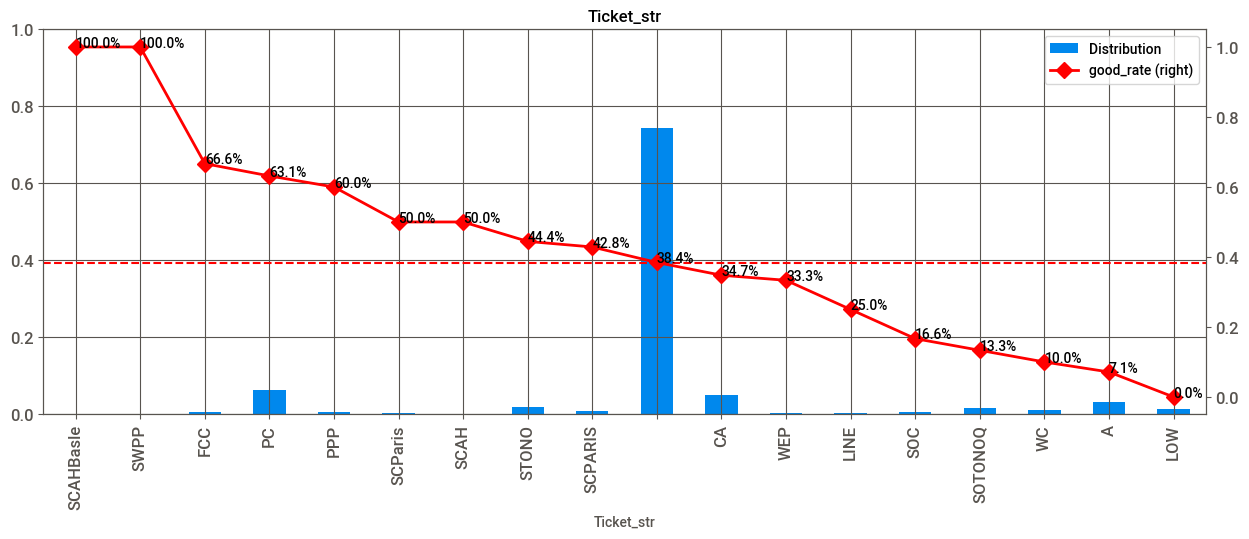

--------------------------------------- NameTitle


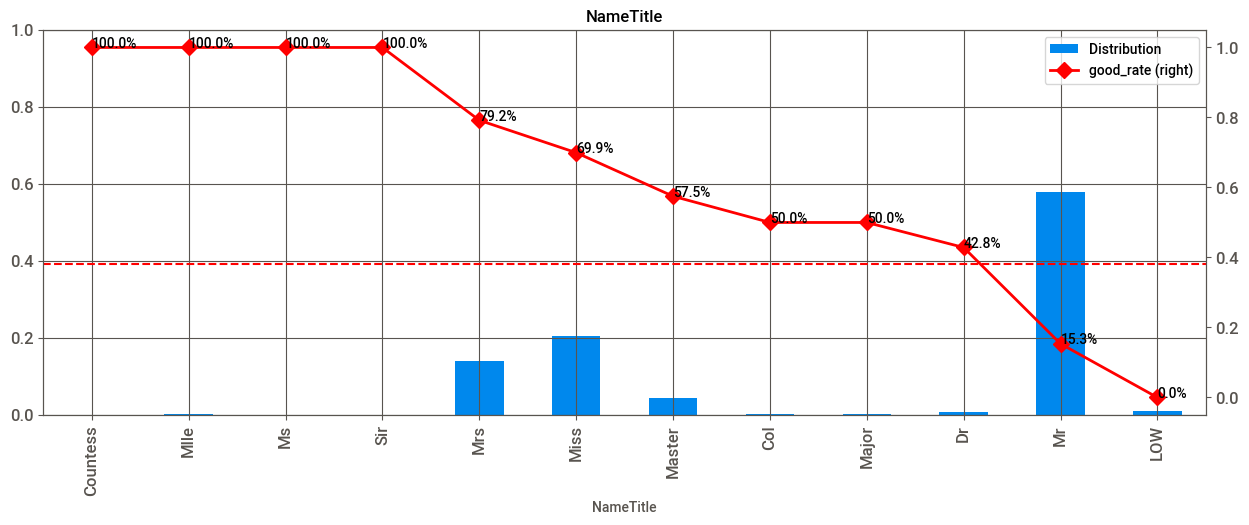

--------------------------------------- Fare


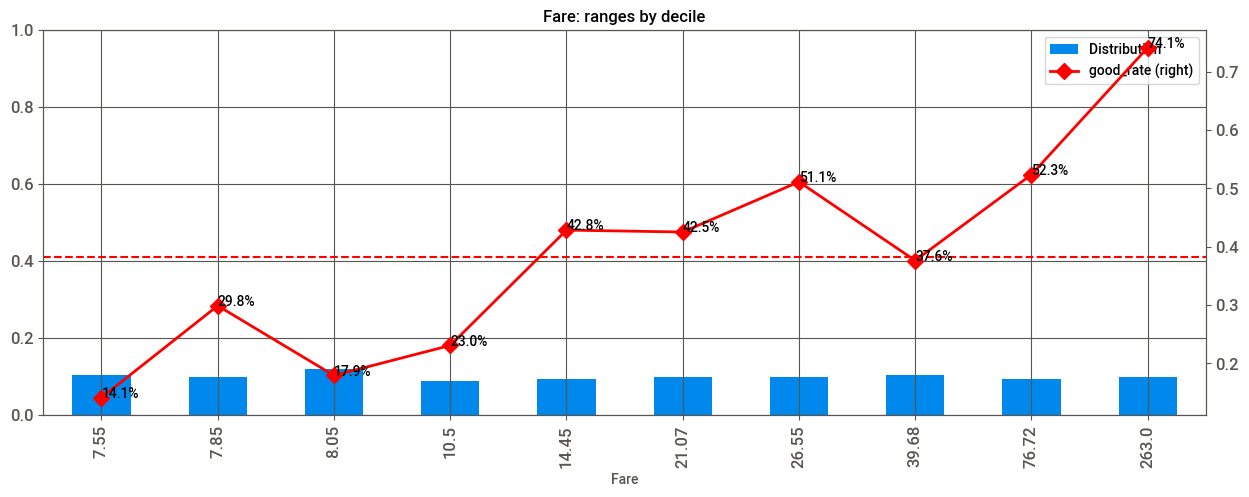

--------------------------------------- SibSp


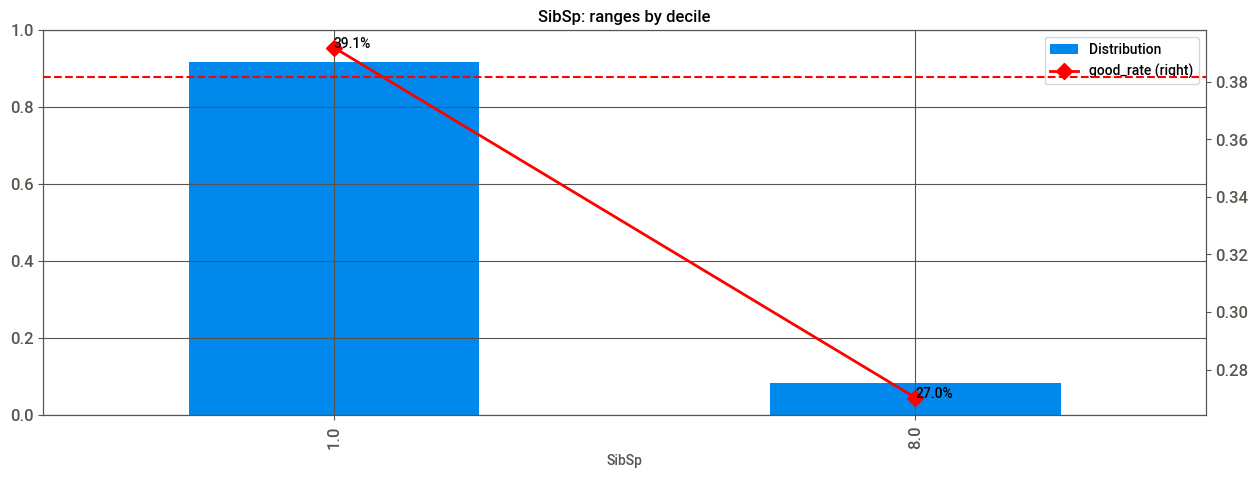

--------------------------------------- Parch


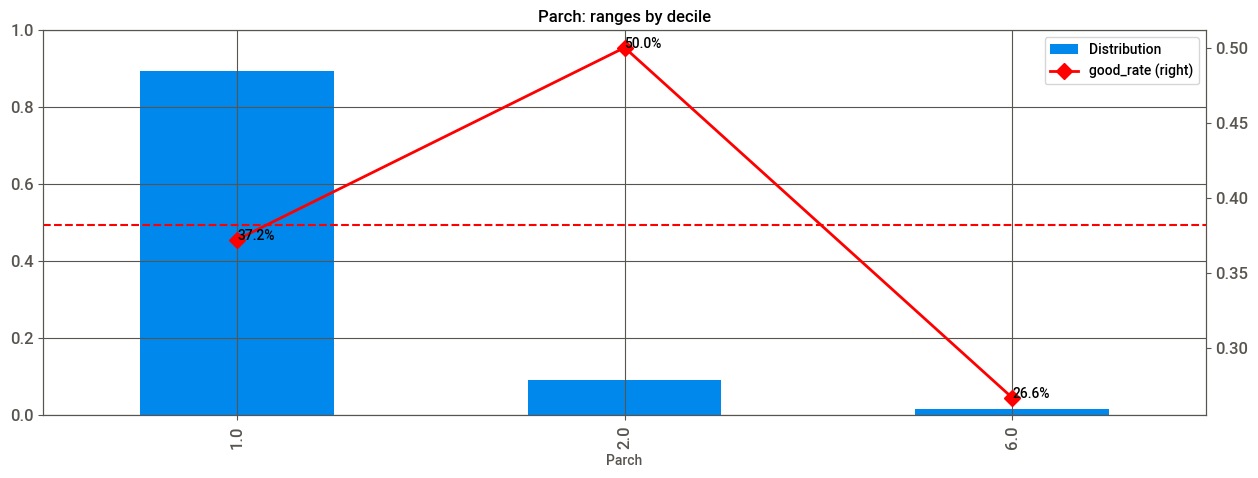

--------------------------------------- Age_Mean


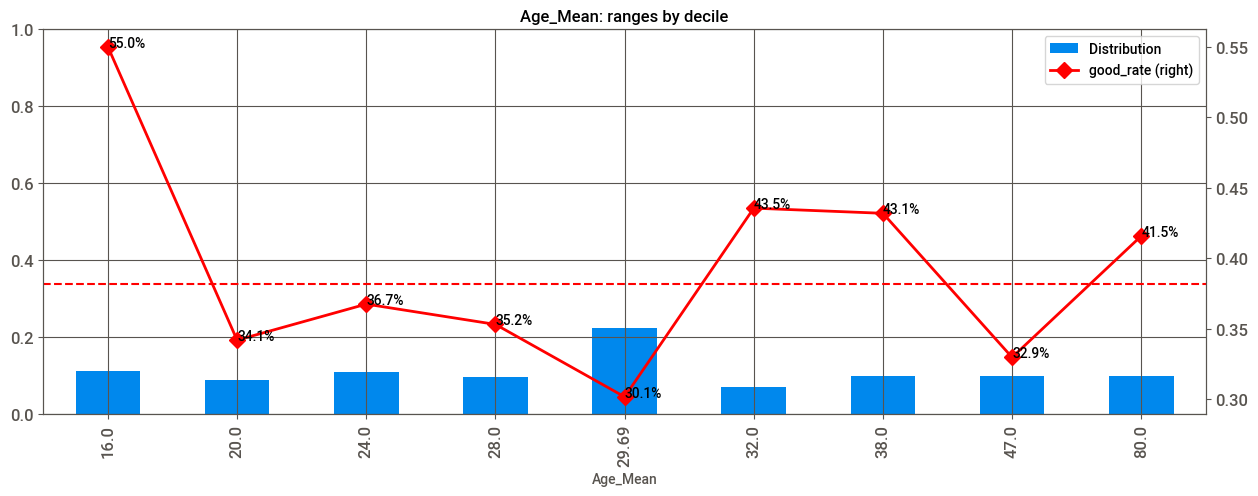

--------------------------------------- Ticket_int


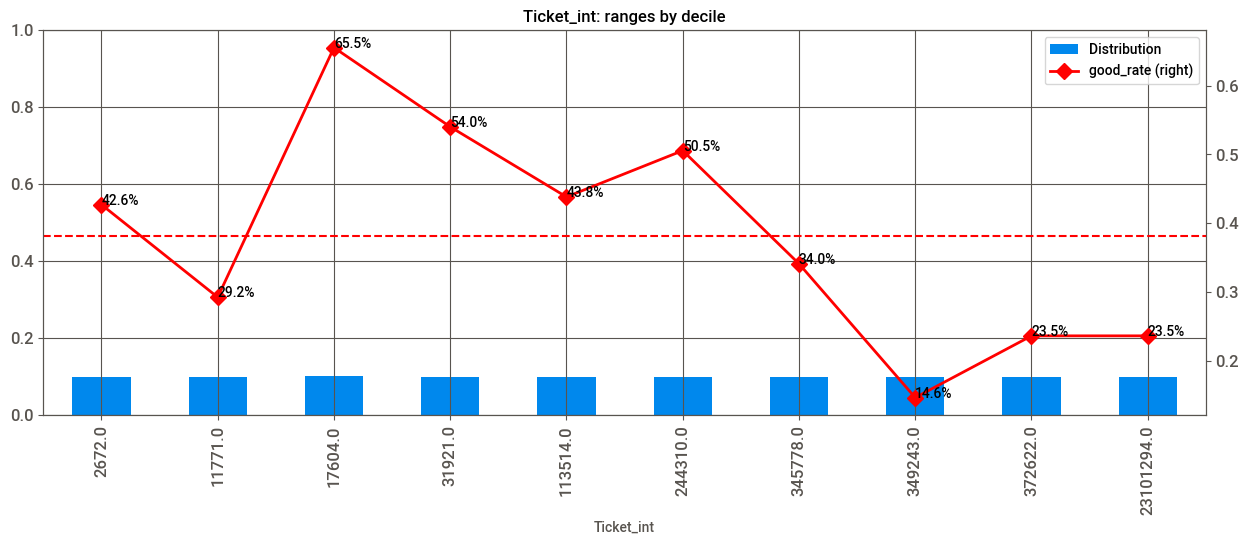

In [29]:
for i in selected_features:
    df_plot_tmp = result_data[i][1]
    df_plot_tmp['Distribution'] = df_plot_tmp.qty / df_plot_tmp.qty.sum()
    if i in CAT:
        print('--------------------------------------- ' + str(i))
        df_plot_tmp = df_plot_tmp.sort_values(by='good_rate', ascending=False)
        df_plot_t1 = df_plot_tmp.loc[:, (i,'Distribution')]
        df_plot_t1 = df_plot_t1.set_index(i)
        df_plot_t2 = df_plot_tmp.loc[:, (i, 'good_rate')]
        df_plot_t2 = df_plot_t2.set_index(i)
        df_plot_t1.Distribution.plot(ylim=[0,1], kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=i)
        ax = df_plot_t2.good_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12\
                                       , marker="D", ms=8, grid=True, color='r', legend=1)
        for p in range(len(df_plot_t2)):
            ax.annotate(str('{0:.1%}'.format(int(df_plot_t2.reset_index().iloc[p,1]*1000)/1000))\
                            ,(df_plot_t2.reset_index().index.values[p]\
                              ,df_plot_t2.reset_index().iloc[p,1]*1))
        target_mean = sum(df_plot_tmp.qty * df_plot_tmp.good_rate) / sum(df_plot_tmp.qty)
        ax.axhline(y=target_mean, color='r', linestyle='--')
        plt.show()
        #display(ax)
    else:
        sort_var = str(i)+"_max"
        print('--------------------------------------- ' + str(i))
        df_plot_tmp[sort_var] = df_plot_tmp[sort_var].astype(float)
        df_plot_tmp = df_plot_tmp.sort_values(by=sort_var)
        df_plot_tmp[i] = df_plot_tmp[sort_var].fillna(999999999.99).astype(float)
        df_plot_tmp[i] = (df_plot_tmp[i]*100).astype(int)/100
        df_plot_tmp[i] = df_plot_tmp[i].astype(str).replace("999999999.99", "missing")
        df_plot_t1 = df_plot_tmp.loc[:, (i, 'Distribution')]
        df_plot_t1 = df_plot_t1.set_index(i)
        df_plot_t2 = df_plot_tmp.loc[:, (i, 'good_rate')]
        df_plot_t2 = df_plot_t2.set_index(i)
        df_plot_t1.Distribution.plot(ylim=[0,1], kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=(i + ": ranges by decile"))
        ax = df_plot_t2.good_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
        for p in range(len(df_plot_t2)):
            ax.annotate(str('{0:.1%}'.format(int(df_plot_t2.reset_index().iloc[p,1]*1000)/1000)), (df_plot_t2.reset_index().index.values[p], df_plot_t2.reset_index().iloc[p,1]*1))        
        target_mean = sum(df_plot_tmp.qty * df_plot_tmp.good_rate) / sum(df_plot_tmp.qty)
        ax.axhline(y=target_mean, color='r', linestyle='--')
        plt.show()
        #display(ax)

# 6. Save final dataset with the selected features to CSV

In [30]:
dataprep_df.loc[:, (selected_features+[VarTarget, VarId, VarDate, 'dataset'])].to_csv('./titanic/dataprep_df.csv', index=False, header=True)